In [1]:
import os
import warnings
import glob
import pickle
import numpy as np
from scipy import io
from mne.viz import plot_topomap
from matplotlib import colors, cm, gridspec, pyplot as plt

plt.style.use("seaborn-dark")
plt.rcParams.update({"xtick.labelsize": 15, "ytick.labelsize": 15})

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
CAF_DOSE = 200 # the caffeine dose in mg (200 or 400)
AGE_GROUP = 0 # -1: all, 0: up to age 30, 1: from age 30

SIGNIFICANT_P = 0.05 # weak significance threshold (grey dots)
SIGNIFICANT_P_STRONG = 0.01 # strong significance threshold (white dots)

PROJECT_PATH = "../data" # path to where the EEG sensor position file is stored
STATS_RESULTS_PATH = "../results/final/statistics200" # directory where statistics results are stored
FOOOF_RESULTS_PATH = "../results/final/fooof200" # directory where single feature ML results are stored
FIGURE_PATH = "../figures" # directory where the figures are saved

STAGES = ["NREM", "REM"] # sleep stages to include in the figure
BANDS = ["delta", "theta", "alpha", "sigma", "beta", "low gamma"] # frequency bands to include in the figure

In [3]:
# load fitted FOOOF models
with open(os.path.join(FOOOF_RESULTS_PATH, "fooof.pkl"), "rb") as f:
    fm = pickle.load(f)

In [4]:
# get age suffix for loading the data depending on age group parameter
age_suffix = ''
if AGE_GROUP == 0:
    age_suffix = "_age_t30"
elif AGE_GROUP == 1:
    age_suffix = "_age_f30"
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

# load statistics data for all features
with open(os.path.join(STATS_RESULTS_PATH, f"statistics{age_suffix}.pickle"), "rb") as file:
    diff = pickle.load(file)

In [5]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, "Coo_caf"))["Cor"].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [6]:
def fmt_feat(name):
    name = name.replace("PSD", "").replace('_', ' ').replace('Shan', '').replace("LZiv", "LZc").replace("OneOverF", f"aperiodic slope").replace("DFA", "scaling exponent")
    return name

In [7]:
fontsize_small = 15
fontsize_big = 20

def plot_spectrum(fm_caf_chs, fm_plac_chs, ax_spectrum, ax_topo, ch_idx=3):
    fm_caf = fm_caf_chs[ch_idx]
    fm_plac = fm_plac_chs[ch_idx]

    ax_spectrum.plot(fm_caf.freqs, fm_caf._ap_fit, label="CAF", color="C0")
    ax_spectrum.plot(
        fm_caf.freqs,
        fm_caf.power_spectrum,
        color="C0",
        linestyle="--",
        linewidth=3,
        alpha=0.3,
    )

    ax_spectrum.plot(fm_plac.freqs, fm_plac._ap_fit, label="PLAC", color="C1")
    ax_spectrum.plot(
        fm_plac.freqs,
        fm_plac.power_spectrum,
        color="C1",
        linestyle="--",
        linewidth=3,
        alpha=0.3,
    )

    ax_spectrum.set_xscale("symlog")
    ax_spectrum.set_yscale("symlog")
    ax_spectrum.set_xlabel("frequency", fontsize=fontsize_small)
    ax_spectrum.set_ylabel("power", fontsize=fontsize_small)
    ax_spectrum.legend(fontsize=fontsize_small, loc="lower left")

    topo_mask = np.zeros(20, dtype=bool)
    topo_mask[ch_idx] = True
    plot_topomap(np.zeros(20), sensor_pos, mask=topo_mask, cmap=colors.ListedColormap((0, 0, 0, 0)),
                 mask_params=dict(marker="*", markersize=15, markerfacecolor="red"), show=False, axes=ax_topo)

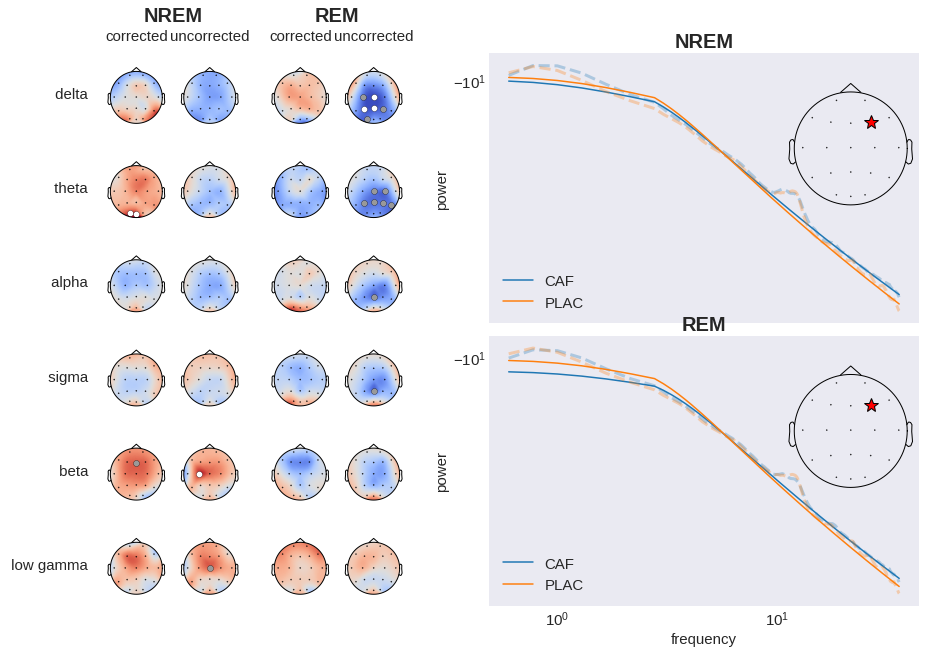

In [9]:
FEATURES = ["PSD{}_delta", "PSD{}_theta", "PSD{}_alpha", "PSD{}_sigma", "PSD{}_beta", "PSD{}_low gamma"]
weak_marker_color = [0.6, 0.6, 0.6]
cmap = "coolwarm"
fontsize_small = 15
fontsize_big = 20

gs = gridspec.GridSpec(len(FEATURES) + 2, len(STAGES) * 2 + 3 + len(FEATURES),
                       width_ratios=[0.2, 1, 1] + [0.1, 1, 1] * (len(STAGES) - 1) + [1] + [1] * len(FEATURES),
                       height_ratios=[0.1, 0.1] + [1] * len(FEATURES))
fig = plt.figure(figsize=(15, 10))

for i, stage in enumerate(STAGES):
    ax = fig.add_subplot(gs[0,i+i*2+1:i+(i+1)*2+1])
    ax.text(0.5, 0.5, stage, ha="center", va="center", fontsize=fontsize_big, weight="bold")
    ax.axis("off")
    
for i in range(4):
    ax = fig.add_subplot(gs[1,i+1+i//2])
    text = "corrected" if i % 2 == 0 else "uncorrected"
    ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=fontsize_small)
    ax.axis("off")
    
for i, feat in enumerate(FEATURES):
    ax = fig.add_subplot(gs[i+2,0])
    ax.text(0.5, 0.5, fmt_feat(feat.format("")), ha="right", va="center", fontsize=fontsize_small)
    ax.axis("off")

axes = np.array([[fig.add_subplot(gs[i+2,j+j//2+1]) for j in range(len(STAGES)*2)] for i in range(len(FEATURES))])
for idx_stage, stage in enumerate(STAGES):
    # compute statistics value range
    vmin_corr = min([min(diff[stage][feat.format("")]["t_statistic"]) for feat in FEATURES])
    vmax_corr = max([max(diff[stage][feat.format("")]["t_statistic"]) for feat in FEATURES])
    vmin_uncorr = min([min(diff[stage][feat.format("Uncorrected")]["t_statistic"]) for feat in FEATURES])
    vmax_uncorr = max([max(diff[stage][feat.format("Uncorrected")]["t_statistic"]) for feat in FEATURES])
    vmin, vmax = min(vmin_corr, vmin_uncorr), max(vmax_corr, vmax_uncorr)
    absvmax = max(abs(vmin), abs(vmax))
    vmin, vmax = -absvmax, absvmax
    
    for idx_feat, feat in enumerate(FEATURES):
        # CORRECTED
        # get significance marker params
        mask = diff[stage][feat.format("")]['p_value'] < SIGNIFICANT_P
        marker_colors = [weak_marker_color] * len(mask)
        for i in np.where(diff[stage][feat.format("")]['p_value'] < SIGNIFICANT_P_STRONG)[0]:
            marker_colors[i] = 'w'
        marker_colors = np.array(marker_colors)[mask]

        # plot topomap
        mappable_stats = plot_topomap(diff[stage][feat.format("")]['t_statistic'],
                                      sensor_pos,
                                      mask=mask,
                                      mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                                      cmap=cmap,
                                      contours=False,
                                      axes=axes[idx_feat,idx_stage*2],
                                      show=False,
                                      vmin=vmin,
                                      vmax=vmax,)[0]
        # UNCORRECTED
        # get significance marker params
        mask = diff[stage][feat.format("Uncorrected")]['p_value'] < SIGNIFICANT_P
        marker_colors = [weak_marker_color] * len(mask)
        for i in np.where(diff[stage][feat.format("Uncorrected")]['p_value'] < SIGNIFICANT_P_STRONG)[0]:
            marker_colors[i] = 'w'
        marker_colors = np.array(marker_colors)[mask]

        # plot topomap
        mappable_stats = plot_topomap(diff[stage][feat.format("Uncorrected")]['t_statistic'],
                                      sensor_pos,
                                      mask=mask,
                                      mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                                      cmap=cmap,
                                      contours=False,
                                      axes=axes[idx_feat,idx_stage*2+1],
                                      show=False,
                                      vmin=vmin,
                                      vmax=vmax,)[0]

ax_spectrum_nrem = fig.add_subplot(gs[2:5,-6:])
ax_topo_nrem = fig.add_subplot(gs[2:4,-2:])
plot_spectrum(fm["NREM"]["CAF"], fm["NREM"]["PLAC"], ax_spectrum_nrem, ax_topo_nrem)
ax_spectrum_nrem.set_title("NREM", fontsize=fontsize_big, weight="bold")

ax_spectrum_rem = fig.add_subplot(gs[5:,-6:])
ax_topo_rem = fig.add_subplot(gs[5:7,-2:])
plot_spectrum(fm["REM"]["CAF"], fm["REM"]["PLAC"], ax_spectrum_rem, ax_topo_rem)
ax_spectrum_rem.set_title("REM", fontsize=fontsize_big, weight="bold")

ax_spectrum_nrem.get_shared_x_axes().join(ax_spectrum_nrem, ax_spectrum_rem)
ax_spectrum_nrem.set_xticklabels([])
ax_spectrum_nrem.set_xlabel("")

plt.show()